# Code Summary

# This notebook adheres to TRIPOD Criteria

# Preprocess Data 
    # select data (A_ variables or non-A_ variables)
    # select the label (y) and remove it from the dataset (X)
    # exclude future variables
    # exclude variables more than 50% blank
    # train/test split (80:20)
    # make a dictionary of which variables are continuous vs ordinal vs categorical
    # normalize training continuous variables to be mean centered on 0, std_dev = 1
    # keep ordinal variables as is (but map unknown or NaN to 99 or -1 or 0)
    # one-hot encoding of categorical variables
    # apply the same training normalization to test data
# Visualize data
    # Plot some initial data distributions
    # Plot covariance matrix heatmap showing which variables correlate most with outcome variables
# Train/Validate
    # Select 5 algorithms which can take normalized continuous variables and one-hot encoded categorical variables and output a probability
    # 1. XGBoost (Extreme Gradient Boosting), 2. LightGBM, 3. CatBoost, 4. Neural Networks, 5. Gradient Boosting Classifier (e.g., scikit-learn's GradientBoostingClassifier)
    # Bootstrapped nested k-fold cross-validation (100-fold bootstrap, k=5, score should be the ROC-AUC score)
    # For the nested part, select a random range of hyperparameters appropriate for each of the 5 algorithms, with 20 different hyperparameter combinations total per algorithm
    # Plot progress bars showing training progress
    # Plot one bar plot per algorithm of performance vs training param combination (thus the x-axis should have 20 ticks)
    # Print out the best hyperparameter combinations for each algorithm
    # Use stacking to get a single aggregate score based on all the 5 models with the best hyperparameter scores
    # Display Results
        # Plot ROC-AUC plot showing the best bootstrapped nested k-fold cross-validation (ROC-AUC) score of each of the 5 algorithms + the 1 stacking algorithm score
        # Plot bar plot showing the best bootstrapped nested k-fold cross-validation (ROC-AUC) score of each of the 5 algorithms + the 1 stacking algorithm score with error bars giving the 95% CI from bootstrapping
        # Convert label probability into binary label (>=0.5 = 1, <0.5 = 0)
        # Use binary labels to get accuracy, sensitivity, specificity, F1-score, and plot confusion matrix
    # Retrain the 5 models (with best hyperparams) and stacked model on the full train dataset (with progress bar)
    # Save the final trained 5 models and stacked model
# Test
    # Use the stacked model and all 5 final trained models to predict the label in the held-out test set
    # Use 100-fold bootstrapping of test set to get 95% CI
    # Display Results
        # Plot ROC-AUC plot showing the best bootstrapped nested k-fold cross-validation (ROC-AUC) score of each of the 5 algorithms + the 1 stacking algorithm score
        # Plot bar plot showing the best bootstrapped nested k-fold cross-validation (ROC-AUC) score of each of the 5 algorithms + the 1 stacking algorithm score with error bars giving the 95% CI from bootstrapping
        # Convert label probability into binary label (>=0.5 = 1, <0.5 = 0)
        # Use binary labels to get accuracy, sensitivity, specificity, F1-score, and plot confusion matrix
     

In [1]:
# save data - done
# add linear regression
# smote fix - done
# find decision threshold - done
# compare high and low risk groups by decision boundary - done
# subgroup analysis over age and race - done
# calibration curves - done
# run with 30 day mortality - implemented, need to run
# sensitivity analysis with train:test split over time (earliest 80% dx cases will be train, later 20% test) - implemented, need to run
# sensitivity analysis with and without feature reduction - implemented, need to run
# SHAP - sorta implemented... needs work...

In [2]:
from ent_utils import *

'''
Toggle experiment settings here
'''

# Record the start time
start_time = datetime.datetime.now()

experiment_name = "30d_mort_pca_analysis"  # Set your experiment name, if any

use_mini_dataset = False
# use_mini_dataset = True # Set to True for testing with a mini-train and test dataset (first 500 entries of each)

dataset_option = "use_full_ncbd_dataset"
# dataset_option = "use_selected_A_dataset" # Use selected A variables only

# outcome_option = "use_30_day_readmission"; class_labels = ['No Readmission','Readmission within 30 Days']; outcome_name = 'READM_HOSP_30_DAYS'
outcome_option = "use_30_day_mortality"; class_labels = ['Living','Deceased within 30 Days']; outcome_name = 'PUF_30_DAY_MORT_CD'
# outcome_option = "use_90_day_mortality"; class_labels = ['Living','Deceased within 90 Days']; outcome_name = 'PUF_90_DAY_MORT_CD'

split_by_dx_date=False
# split_by_dx_date=True # Set to True for sensitivity analysis for spliting by diagnosis date: train (early cases) vs test (late cases)

exclude_variables_more_than_x_proportion_blank = 0.5

train_test_split = [80,20]

use_lasso = True; use_rfe = False; use_rf = False; use_boruta = False; overlap_mode="all_overlap"

use_PCA = True; number_of_PCA_components = 100
# use_PCA = False

n_bootstraps_for_training = 1
n_bootstraps_for_results = 100
num_k_fold_splits = 5

if use_mini_dataset:
    n_bootstraps_for_training = 2
    n_bootstraps_for_results = 5
    num_k_fold_splits = 2

2024-05-05 00:58:23.714513: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
# Load the database .sav file
df, meta = pyreadstat.read_sav("Aman_NCDB ML HNSCC 30-day Database v2.sav")


In [4]:
# '''
# Show data distribution and basic statistics
# '''

# visualize_demographics(df)

# # Print out all the column names of the DataFrame
# print(df.columns.tolist())

# # Generate data summaries
# demographic_summaries, age_stats, ln_stats = summarize_demographics(df)

# print("Age Statistics:")
# display(age_stats)

# print("Lymph Node Statistics:")
# display(ln_stats)

# print("\nDemographic Summaries:")
# for key, value in demographic_summaries.items():
#     print(f"\n{key}:")
#     display(value)


In [5]:
# Preprocess Data 
    # select data (A_ variables or non-A_ variables)
    # select the label (y) and remove it from the dataset (X)
    # exclude future variables
    # exclude variables more than 50% blank
    # train/test split (80:20)
    # make a dictionary of which variables are continuous vs ordinal vs categorical
    # normalize training continuous variables to be mean centered on 0, std_dev = 1
    # keep ordinal variables as is (but map unknown or NaN to 99 or -1 or 0)
    # one-hot encoding of categorical variables
    # apply the same training normalization to test data
    
X, y = filter_variables(df,
                       dataset_option,
                       outcome_option, 
                       exclude_variables_more_than_x_proportion_blank, 
                       verbose=True, 
                       plot_histogram=False)

print('Final columns')
print(X.columns.tolist())

Using full NCBD dataset
Removing "A_" variables
Outcome is 30 d mortality
Number of entries excluded due to missing outcomes: 0
Removing treatment-related variables
Excluded variables and their proportion of blanks:
CS_METS_DX_BONE: 51.59%
CS_METS_DX_BRAIN: 51.59%
CS_METS_DX_LIVER: 51.59%
CS_METS_DX_LUNG: 51.59%
MED_INC_QUAR_2020: 100.00%
METS_AT_DX_BONE: 69.17%
METS_AT_DX_BRAIN: 69.17%
METS_AT_DX_DISTANT_LN: 69.17%
METS_AT_DX_LIVER: 69.17%
METS_AT_DX_LUNG: 69.17%
METS_AT_DX_OTHER: 69.17%
NO_HSD_QUAR_2020: 100.00%
SCHEMA_DISC_1: 99.99%
SCHEMA_DISC_2: 98.08%
SCHEMA_DISC_3: 100.00%
SLN_EXAM: 100.00%
SLN_POS: 100.00%
Final columns
['ADENOID_CYSTIC_BSLD', 'ADENOPATHY', 'AFP_POST_ORCH_RANGE', 'AFP_POST_ORCH_VALUE', 'AFP_PRE_INTERP', 'AFP_PRE_ORCH_RANGE', 'AFP_PRE_ORCH_VALUE', 'AFP_PRE_VALUE', 'AGE', 'AJCC_ID', 'AJCC_TNM_CLIN_M', 'AJCC_TNM_CLIN_N', 'AJCC_TNM_CLIN_N_SFX', 'AJCC_TNM_CLIN_STG_GRP', 'AJCC_TNM_CLIN_T', 'AJCC_TNM_CLIN_T_SFX', 'AJCC_TNM_PATH_M', 'AJCC_TNM_PATH_N', 'AJCC_TNM_PATH_N_

In [6]:
# Train:test split:
    # split using train_test_split variable = [80:20]
X_train_raw, y_train_raw, X_test_raw, y_test_raw = custom_train_test_split(X,y,train_test_split,split_by_dx_date=split_by_dx_date)

# Merging X and y datasets for both train and test and saving train/test data as .sav files
train_data = pd.merge(X_train_raw, y_train_raw, left_index=True, right_index=True); test_data = pd.merge(X_test_raw, y_test_raw, left_index=True, right_index=True)
# Save train and test data as SPSS .sav file
pyreadstat.write_sav(train_data, f'{experiment_name}_train_data.sav'); pyreadstat.write_sav(test_data, f'{experiment_name}_test_data.sav')

# Data normalization:
    # make a dictionary of which variables are continuous vs ordinal vs categorical
        # normalize training continuous variables to be mean centered on 0, std_dev = 1
        # keep ordinal variables as is (but map unknown or NaN to 99 or -1 or 0)
        # one-hot encoding of categorical variables
    # apply the same training normalization to test data

X_train, X_test = normalize(X_train_raw, X_test_raw)

# Outcome binarization:
    # Values of 0 will stay as 0
    # Values >= 1 will become 1

y_train, y_test = binarize(y_train_raw, y_test_raw)


In [7]:
# import pandas as pd
# import numpy as np
# from scipy.stats import chi2_contingency, pearsonr

# # Function to calculate category counts and percentages
# def calculate_counts_and_percents(data, feature):
#     counts = data[feature].value_counts(dropna=False)
#     percents = data[feature].value_counts(normalize=True, dropna=False) * 100
#     return counts, percents

# # Prepare the demographics table
# features = sorted(X_train_raw.columns)
# rows_list = []

# for feature in features:
#     train_counts, train_percents = calculate_counts_and_percents(X_train_raw, feature)
#     test_counts, test_percents = calculate_counts_and_percents(X_test_raw, feature)
    
#     # Only include categories with sufficient data in both training and testing datasets
#     common_categories = train_counts.index.intersection(test_counts.index)
    
#     for category in common_categories:
#         if train_counts[category] > 1 and test_counts[category] > 1:  # Ensure at least two data points
#             # Calculating chi-squared test
#             contingency_table = pd.crosstab(X_train_raw[feature] == category, X_test_raw[feature] == category)
#             chi2, p_val, _, _ = chi2_contingency(contingency_table) if not contingency_table.empty else (np.nan, np.nan, np.nan, np.nan)
            
#             # Calculating correlations safely
#             train_correlated = X_train_raw[feature][X_train_raw[feature] == category]
#             test_correlated = X_test_raw[feature][X_test_raw[feature] == category]
#             if len(train_correlated) > 1 and len(test_correlated) > 1:
#                 train_corr = pearsonr(train_correlated, y_train_raw[X_train_raw[feature] == category])[0]
#                 test_corr = pearsonr(test_correlated, y_test_raw[X_test_raw[feature] == category])[0]
#             else:
#                 train_corr, test_corr = np.nan, np.nan
            
#             row = {
#                 'Feature': feature,
#                 'Category': category,
#                 'Train Count': train_counts[category],
#                 'Train Percent': train_percents[category],
#                 'Test Count': test_counts[category],
#                 'Test Percent': test_percents[category],
#                 'P-Value': p_val,
#                 'Train Correlation': train_corr,
#                 'Test Correlation': test_corr
#             }
#             rows_list.append(row)

#     # Add missing value row if there are any
#     if pd.isnull(train_counts.get(np.nan, 0)) or pd.isnull(test_counts.get(np.nan, 0)):
#         row_missing = {
#             'Feature': feature,
#             'Category': 'Missing',
#             'Train Count': X_train_raw[feature].isna().sum(),
#             'Train Percent': X_train_raw[feature].isna().mean() * 100,
#             'Test Count': X_test_raw[feature].isna().sum(),
#             'Test Percent': X_test_raw[feature].isna().mean() * 100,
#             'P-Value': np.nan,
#             'Train Correlation': np.nan,
#             'Test Correlation': np.nan
#         }
#         rows_list.append(row_missing)

# demographics_table = pd.DataFrame(rows_list)

# # Set more appealing formatting for percentages, etc.
# demographics_table['Train Percent'] = demographics_table['Train Percent'].map('{:.2f}%'.format)
# demographics_table['Test Percent'] = demographics_table['Test Percent'].map('{:.2f}%'.format)

# # Save to Excel
# demographics_table.to_excel(f"{experiment_name}_demographics_table.xlsx", index=False)


In [8]:
# Calculate the proportions
train_positives_percentage = (np.sum(y_train) / len(y_train)) * 100; train_negatives_percentage = 100 - train_positives_percentage
test_positives_percentage = (np.sum(y_test) / len(y_test)) * 100; test_negatives_percentage = 100 - test_positives_percentage

# Format and print the proportions
print(f"Train data: {train_positives_percentage:.2f}%:{train_negatives_percentage:.2f}% positive:negative cases")
print(f"Test data: {test_positives_percentage:.2f}%:{test_negatives_percentage:.2f}% positive:negative cases")


Train data: 0.81%:99.19% positive:negative cases
Test data: 0.77%:99.23% positive:negative cases


In [9]:
# Optionally reduce the number of features using various feature reduction methods
X_train,X_test = feature_reduction(use_lasso,use_rfe,use_rf,use_boruta,X_train,X_test,y_train,y_test,overlap_mode="all_overlap")     




There are 1599 features in the training data.


/Users/DanielFu/miniconda3/envs/aman/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:664: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.05574051757315601, tolerance: 0.05297112304290943
  model = cd_fast.enet_coordinate_descent_gram(
/Users/DanielFu/miniconda3/envs/aman/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:664: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.5633611867405648, tolerance: 0.05297112304290943
  model = cd_fast.enet_coordinate_descent_gram(
/Users/DanielFu/miniconda3/envs/aman/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:664: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.0404292831971134, tolerance: 0.05297112304290943
  model = cd_fast.enet_coordinate_descent_gram(
/Users/DanielFu



Lasso regression selected 101 important features in the training data.


After combining overlapping reduced features from multiple methods, 101 features remain.


X_train and X_test now have 101 features each from the feature reduction.


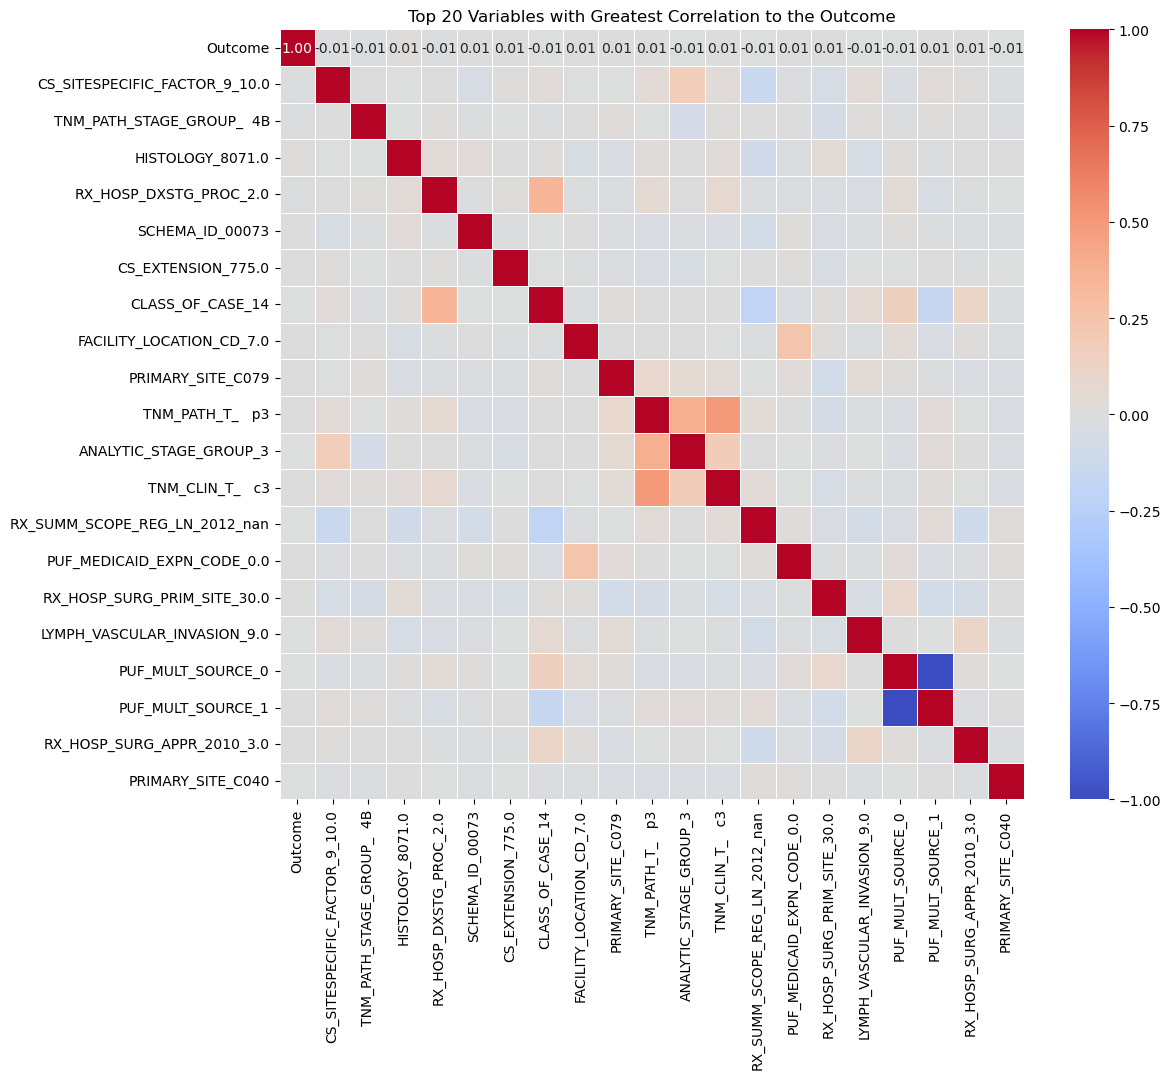

In [10]:
# Plot the covariance heatmap after feature reduction (or after preprocessing if feature reduction was not performed)
plot_covariance_heatmap(X_train, y_train, top_n=20)

In [11]:
# Optionally use PCA to transform the data features into principal component space
if use_PCA:
    X_train,X_test = pca_transform(X_train,X_test,number_of_PCA_components)

# Use SMOTE to resample the training data to make it more balanced
X_train,y_train = SMOTE_resample(X_train, X_test, y_train, y_test, sampling_strategy=0.2)

print('Data processing complete')
print('X_train shape: ',X_train.shape); print('X_test shape: ',X_test.shape); print('y_train shape: ',y_train.shape); print('y_test shape: ',y_test.shape)

# Save the variables to a file
with open(f'{experiment_name}_data_variables.pkl', 'wb') as f:
    pickle.dump((X_train, X_test, y_train, y_test), f)

print('Final columns')
print(X.columns.tolist())

There are 100 features in the training data after PCA.


There are 670.0 or 1% positive examples of out 83112 samples in the training data.
There are 159.0 or 1% positive examples of out 20779 samples in the test data.


After SMOTE there are 16488.0 or 17% positive examples in the training data out of 98930 samples in the training data.
Data processing complete
X_train shape:  (98930, 100)
X_test shape:  (20779, 100)
y_train shape:  (98930,)
y_test shape:  (20779,)
Final columns
['ADENOID_CYSTIC_BSLD', 'ADENOPATHY', 'AFP_POST_ORCH_RANGE', 'AFP_POST_ORCH_VALUE', 'AFP_PRE_INTERP', 'AFP_PRE_ORCH_RANGE', 'AFP_PRE_ORCH_VALUE', 'AFP_PRE_VALUE', 'AGE', 'AJCC_ID', 'AJCC_TNM_CLIN_M', 'AJCC_TNM_CLIN_N', 'AJCC_TNM_CLIN_N_SFX', 'AJCC_TNM_CLIN_STG_GRP', 'AJCC_TNM_CLIN_T', 'AJCC_TNM_CLIN_T_SFX', 'AJCC_TNM_PATH_M', 'AJCC_TNM_PATH_N', 'AJCC_TNM_PATH_N_SFX', 'AJCC_TNM_PATH_STG_GRP', 'AJCC_TNM_PATH_T', 'AJCC_TNM_PATH_T_SFX', 'AJCC_TNM_POST_PATH_M', 'AJCC_TNM_POST_PATH_N', 'AJCC_TNM_POST_PATH_N_SFX', 'A

In [12]:
'''
Select 5 algorithms which can take normalized continuous variables and one-hot encoded categorical variables and output a probability
    1. XGBoost (Extreme Gradient Boosting)
    2. SGD Logistic Regression
    3. Logistic Regression
    4. CatBoost
    5. SVC
    (6.) LightGBM - too much memory requirement
    (7.) Neural Networks - too computationally expensive
    (8.) Gradient Boosting Classifier (e.g., scikit-learn's GradientBoostingClassifier) - too computationally expensive
Bootstrapped nested k-fold cross-validation (100-fold bootstrap, k=5, score should be the ROC-AUC score)
For the nested part, select a random range of hyperparameters appropriate for each of the 5 algorithms, with 20 different hyperparameter combinations total per algorithm
Plot progress bars showing training progress
Meh - Plot one bar plot per algorithm of ROC-AUC vs training param combination (thus the x-axis should have 20 ticks)
Print out the best hyperparameter combinations for each algorithm
Use stacking to get a single aggregate score based on all the 5 models with the best hyperparameter scores
Display Results
    Plot ROC-AUC plot showing the best bootstrapped nested k-fold cross-validation (ROC-AUC) score of each of the 5 algorithms + the 1 stacking algorithm score
    Plot bar plot showing the best bootstrapped nested k-fold cross-validation (ROC-AUC) score of each of the 5 algorithms + the 1 stacking algorithm score with error bars giving the 95% CI from bootstrapping
    Convert label probability into binary label (>=0.5 = 1, <0.5 = 0)
    Use binary labels to get accuracy, sensitivity, specificity, F1-score, and plot confusion matrix
Retrain the 5 models (with best hyperparams) and stacked model on the full train dataset (with progress bar)
Save the final trained 5 models and stacked model
    '''
# # Load the variables back from the file
# with open(f'{experiment_name}_data_variables.pkl', 'rb') as f:
#     X_train, X_test, y_train, y_test = pickle.load(f)

X_small = X_train[:500] # small version for testing
y_small = y_train[:500].ravel() # small version for testing

# Dictionary to collect all_models from each iteration
all_models = {}

# Iterate over each sub-dictionary in models_hyperparams
for model_name, model_hyperparams in models_hyperparams.items():
    save_filename = f'{experiment_name}_{model_name}_results_and_cv_model.pkl'
    
    # Check if this model's combined file already exists, if so, load it
    try:
        with open(save_filename, 'rb') as file:
            combined_data = pickle.load(file)
        results = combined_data["results"]
        model = combined_data["model"]
        print(f"Loaded saved combined file for {model_name}")
    except:
        # If not found, process, save, and combine this model and results
        if use_mini_dataset:
            results, model = process_and_save_combined(model_name, model_hyperparams, X_small, y_small, n_bootstraps_for_training, num_k_fold_splits, experiment_name)
        else:
            results, model = process_and_save_combined(model_name, model_hyperparams, X_train, y_train, n_bootstraps_for_training, num_k_fold_splits, experiment_name)
        print(f"Processed, saved, and combined for {model_name}")
    
    # Collect this model
    all_models.update(model)


Loaded saved combined file for XGBoost
Loaded saved combined file for CatBoost
Loaded saved combined file for Logistic Regression
Loaded saved combined file for SGD Logistic Regression
Loaded saved combined file for Gradient Boosting


In [13]:
# Create a stacked model which incorporates all models
stacked_model = stack_models(all_models)

# Check if this model's combined file already exists, if so, load it
save_filename = f'{experiment_name}_trained_stacked_model.pkl'
try:
    with open(save_filename, 'rb') as file:
        pickle.dump(trained_stacked_model, file)
    with open(f'{experiment_name}_trained_all_models.pkl', 'rb') as file:
        pickle.dump(trained_stacked_model, file)
    print(f"Loaded saved trained models for {experiment_name}")
except:
    print('Retraining all models plus stacked model on the full training dataset...')
    if use_mini_dataset:
        trained_stacked_model, trained_all_models = retrain_models(stacked_model, all_models, 
                                                               X_small, y_small)
    else:
        trained_stacked_model, trained_all_models = retrain_models(stacked_model, all_models, 
                                                               X_train, y_train)
    # Save stacked_model
    with open(f'{experiment_name}_trained_stacked_model.pkl', 'wb') as file:
        pickle.dump(trained_stacked_model, file)
    # Save all_models
    with open(f'{experiment_name}_trained_all_models.pkl', 'wb') as file:
        pickle.dump(trained_all_models, file)


Retraining all models plus stacked model on the full training dataset...


Training performance results


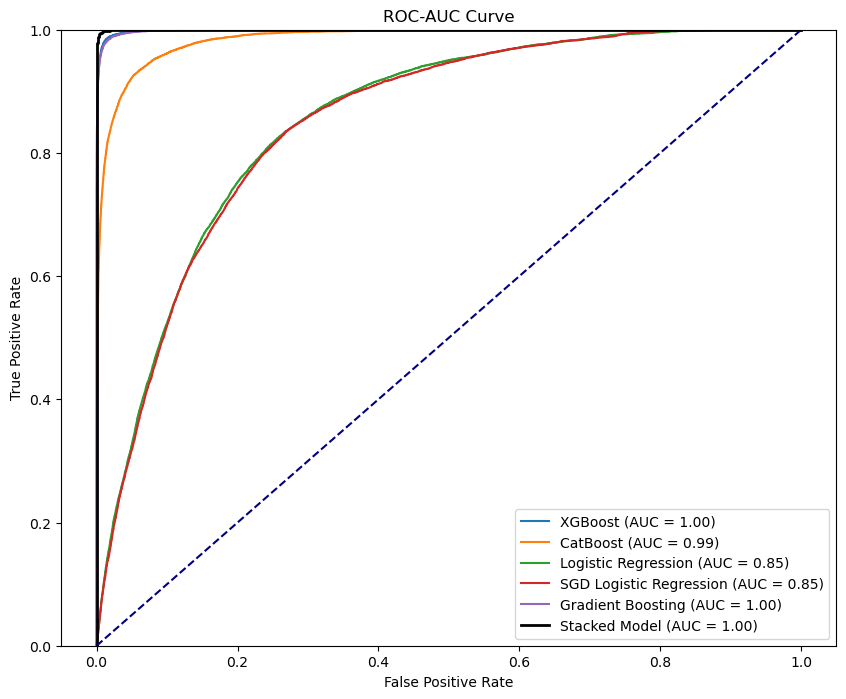

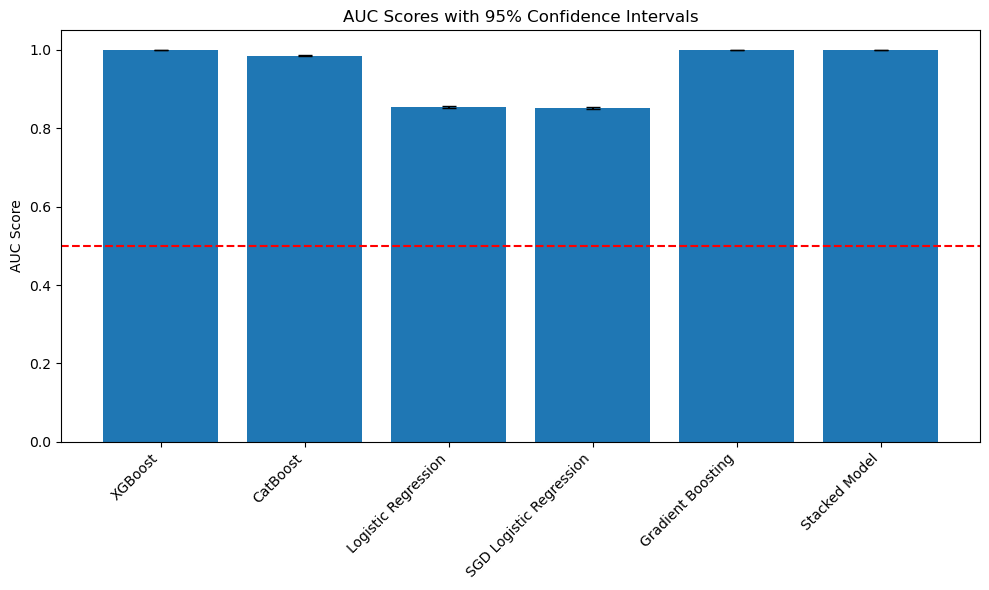

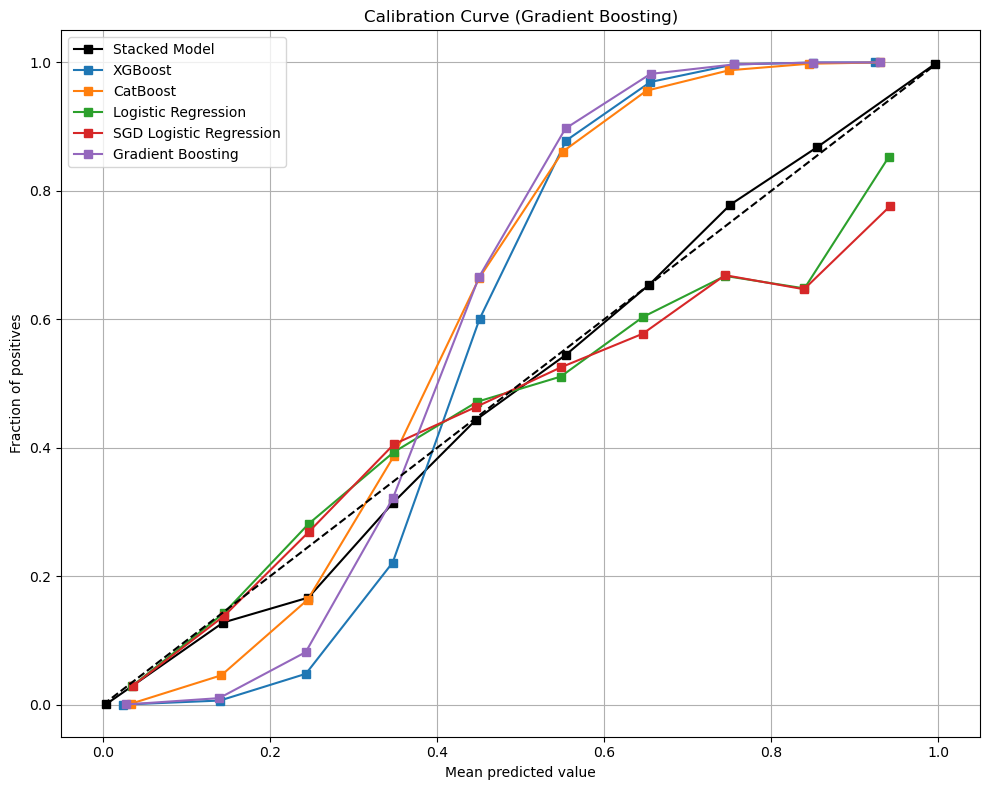

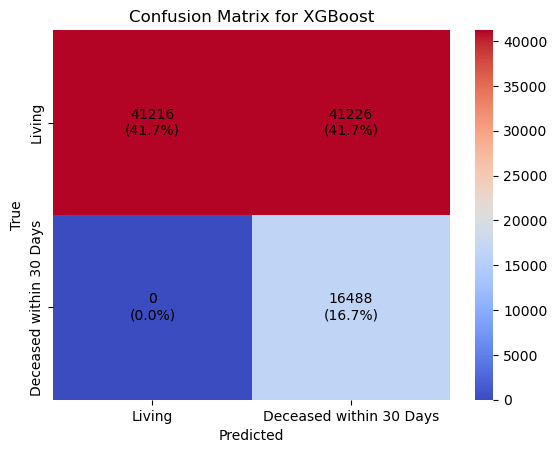


XGBoost:
AUC: 1.00 (95% CI: 1.00-1.00)
Accuracy: 0.58 (95% CI: 0.58-0.59)
Sensitivity: 1.00 (95% CI: 1.00-1.00)
Specificity: 0.50 (95% CI: 0.50-0.50)
F1-Score: 0.44 (95% CI: 0.44-0.45)


/Users/DanielFu/AmanResearch/ent_utils.py:1296: RuntimeWarning: divide by zero encountered in scalar divide
  rel_risk = abs_risk_high / abs_risk_low
/Users/DanielFu/AmanResearch/ent_utils.py:1302: RuntimeWarning: divide by zero encountered in scalar divide
  mean_rr, ci_rr_lower, ci_rr_upper = bootstrap_confidence_interval(y_true, y_pred, lambda y, y_pred: np.mean(y[y_pred==1]) / np.mean(y[y_pred==0]), n_bootstraps)
/Users/DanielFu/miniconda3/envs/aman/lib/python3.12/site-packages/numpy/lib/function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


Relative Risk: inf (95% CI: nan-nan)
Absolute Risk High: 0.2857 (95% CI: 0.2823-0.2887)
Absolute Risk Low: 0.0000 (95% CI: 0.0000-0.0000)
Attributable Risk: 0.2857 (95% CI: 0.2823-0.2887)
P-value for group comparison: 0.000000000


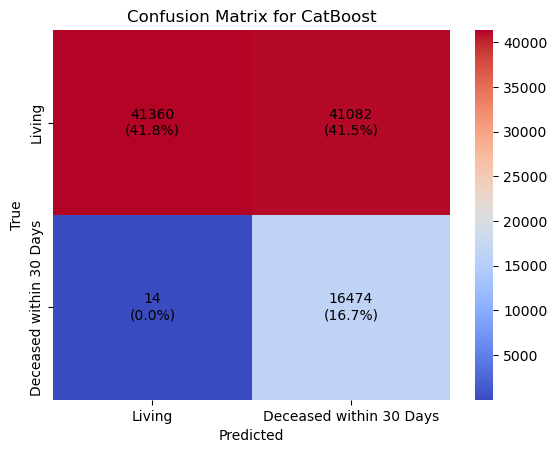


CatBoost:
AUC: 0.99 (95% CI: 0.98-0.99)
Accuracy: 0.58 (95% CI: 0.58-0.59)
Sensitivity: 1.00 (95% CI: 1.00-1.00)
Specificity: 0.50 (95% CI: 0.50-0.51)
F1-Score: 0.44 (95% CI: 0.44-0.45)
Relative Risk: 845.88 (95% CI: 590.89-1822.06)
Absolute Risk High: 0.2862 (95% CI: 0.2826-0.2886)
Absolute Risk Low: 0.0003 (95% CI: 0.0002-0.0005)
Attributable Risk: 0.2859 (95% CI: 0.2824-0.2882)
P-value for group comparison: 0.000000000


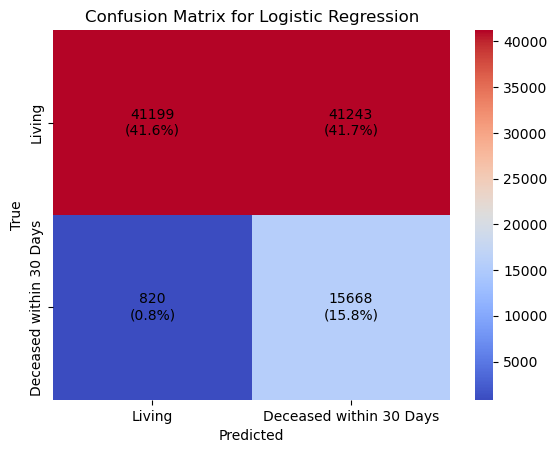


Logistic Regression:
AUC: 0.85 (95% CI: 0.85-0.86)
Accuracy: 0.57 (95% CI: 0.57-0.58)
Sensitivity: 0.95 (95% CI: 0.95-0.95)
Specificity: 0.50 (95% CI: 0.50-0.50)
F1-Score: 0.43 (95% CI: 0.42-0.43)
Relative Risk: 14.11 (95% CI: 13.01-14.97)
Absolute Risk High: 0.2753 (95% CI: 0.2717-0.2781)
Absolute Risk Low: 0.0195 (95% CI: 0.0184-0.0211)
Attributable Risk: 0.2558 (95% CI: 0.2514-0.2588)
P-value for group comparison: 0.000000000


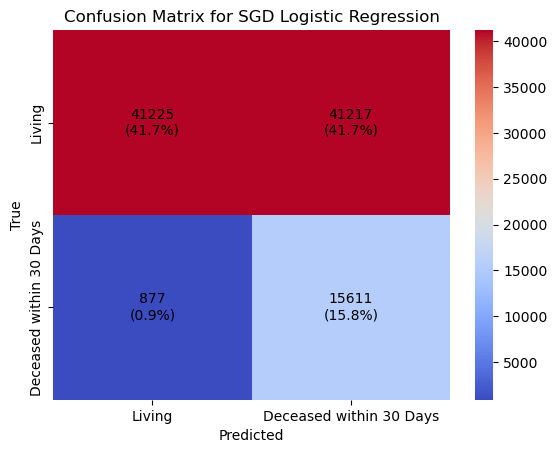


SGD Logistic Regression:
AUC: 0.85 (95% CI: 0.85-0.85)
Accuracy: 0.57 (95% CI: 0.57-0.58)
Sensitivity: 0.95 (95% CI: 0.94-0.95)
Specificity: 0.50 (95% CI: 0.50-0.50)
F1-Score: 0.43 (95% CI: 0.42-0.43)
Relative Risk: 13.19 (95% CI: 12.39-14.10)
Absolute Risk High: 0.2747 (95% CI: 0.2707-0.2774)
Absolute Risk Low: 0.0208 (95% CI: 0.0195-0.0222)
Attributable Risk: 0.2539 (95% CI: 0.2503-0.2566)
P-value for group comparison: 0.000000000


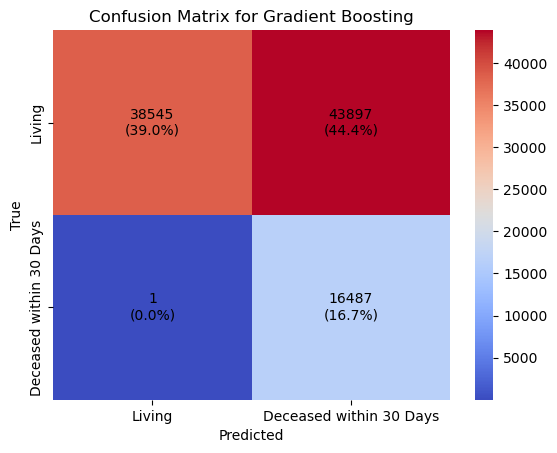


Gradient Boosting:
AUC: 1.00 (95% CI: 1.00-1.00)
Accuracy: 0.56 (95% CI: 0.55-0.56)
Sensitivity: 1.00 (95% CI: 1.00-1.00)
Specificity: 0.47 (95% CI: 0.46-0.47)
F1-Score: 0.43 (95% CI: 0.42-0.43)


/Users/DanielFu/AmanResearch/ent_utils.py:1302: RuntimeWarning: divide by zero encountered in scalar divide
  mean_rr, ci_rr_lower, ci_rr_upper = bootstrap_confidence_interval(y_true, y_pred, lambda y, y_pred: np.mean(y[y_pred==1]) / np.mean(y[y_pred==0]), n_bootstraps)
/Users/DanielFu/miniconda3/envs/aman/lib/python3.12/site-packages/numpy/lib/function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


Relative Risk: 10524.44 (95% CI: 3475.95-nan)
Absolute Risk High: 0.2730 (95% CI: 0.2696-0.2756)
Absolute Risk Low: 0.0000 (95% CI: 0.0000-0.0001)
Attributable Risk: 0.2730 (95% CI: 0.2696-0.2756)
P-value for group comparison: 0.000000000


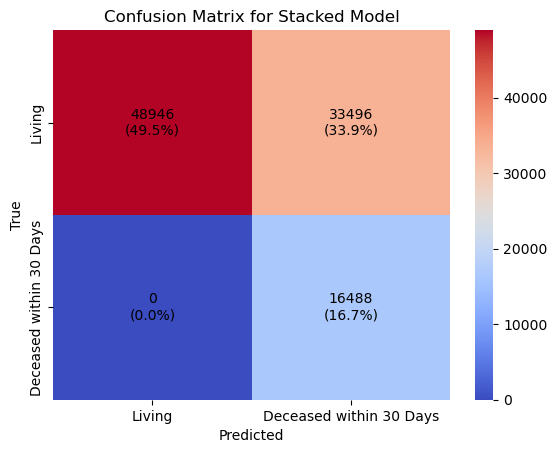


Stacked Model:
AUC: 1.00 (95% CI: 1.00-1.00)
Accuracy: 0.66 (95% CI: 0.66-0.66)
Sensitivity: 1.00 (95% CI: 1.00-1.00)
Specificity: 0.59 (95% CI: 0.59-0.60)
F1-Score: 0.50 (95% CI: 0.49-0.50)


/Users/DanielFu/AmanResearch/ent_utils.py:1296: RuntimeWarning: divide by zero encountered in scalar divide
  rel_risk = abs_risk_high / abs_risk_low
/Users/DanielFu/AmanResearch/ent_utils.py:1302: RuntimeWarning: divide by zero encountered in scalar divide
  mean_rr, ci_rr_lower, ci_rr_upper = bootstrap_confidence_interval(y_true, y_pred, lambda y, y_pred: np.mean(y[y_pred==1]) / np.mean(y[y_pred==0]), n_bootstraps)
/Users/DanielFu/miniconda3/envs/aman/lib/python3.12/site-packages/numpy/lib/function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


Relative Risk: inf (95% CI: nan-nan)
Absolute Risk High: 0.3299 (95% CI: 0.3262-0.3335)
Absolute Risk Low: 0.0000 (95% CI: 0.0000-0.0000)
Attributable Risk: 0.3299 (95% CI: 0.3262-0.3335)
P-value for group comparison: 0.000000000
Testing performance results


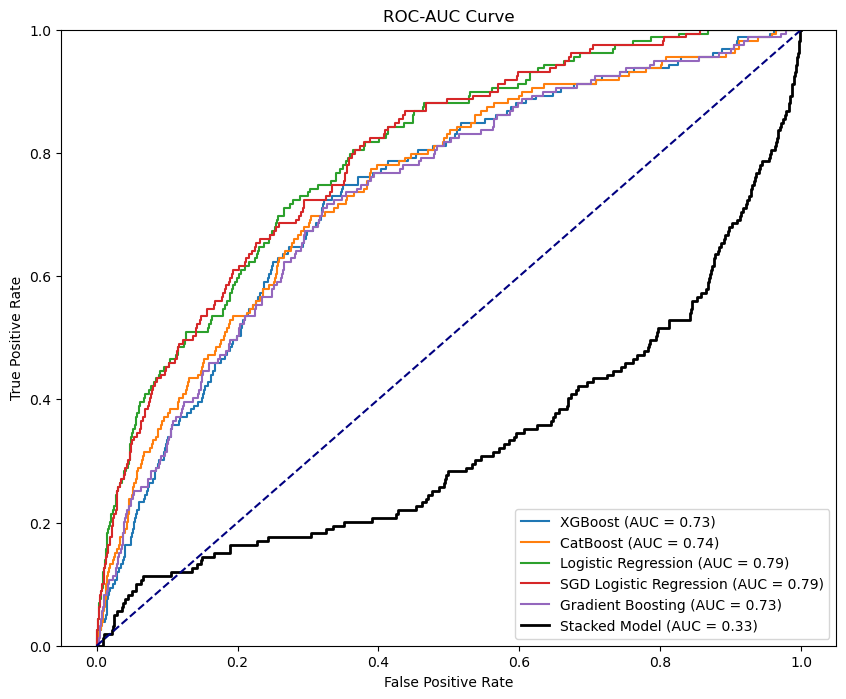

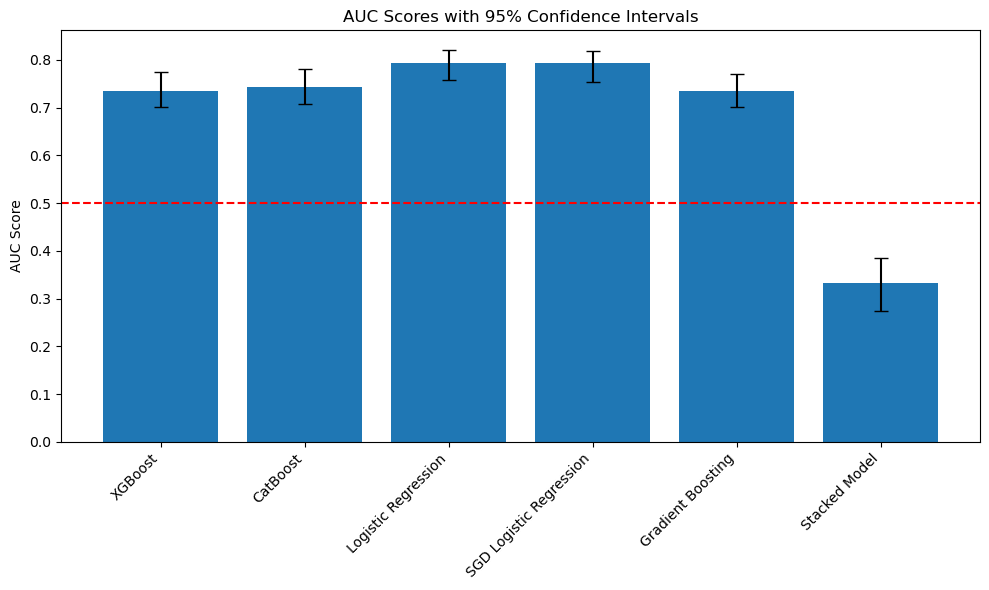

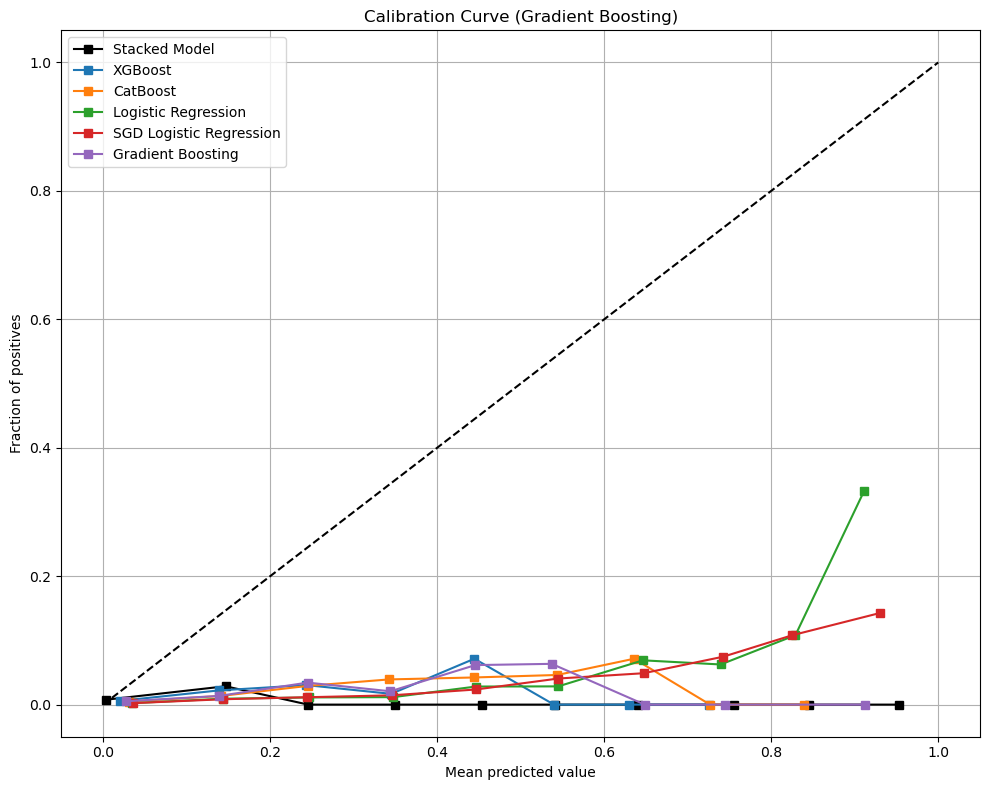

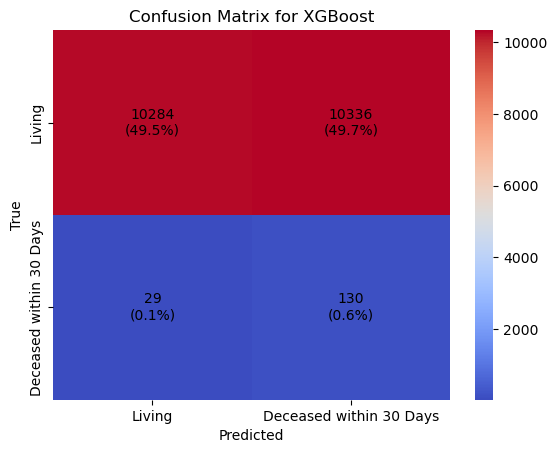


XGBoost:
AUC: 0.74 (95% CI: 0.70-0.77)
Accuracy: 0.50 (95% CI: 0.49-0.51)
Sensitivity: 0.82 (95% CI: 0.77-0.88)
Specificity: 0.50 (95% CI: 0.49-0.51)
F1-Score: 0.02 (95% CI: 0.02-0.03)
Relative Risk: 4.42 (95% CI: 3.23-7.35)
Absolute Risk High: 0.0124 (95% CI: 0.0105-0.0149)
Absolute Risk Low: 0.0028 (95% CI: 0.0018-0.0038)
Attributable Risk: 0.0096 (95% CI: 0.0075-0.0120)
P-value for group comparison: 0.000000000


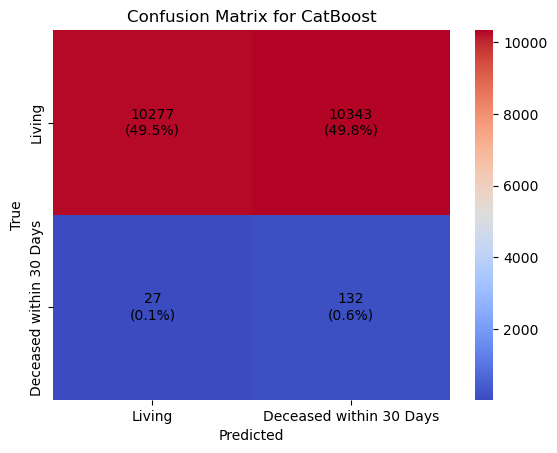


CatBoost:
AUC: 0.74 (95% CI: 0.71-0.78)
Accuracy: 0.50 (95% CI: 0.50-0.51)
Sensitivity: 0.83 (95% CI: 0.77-0.88)
Specificity: 0.50 (95% CI: 0.49-0.50)
F1-Score: 0.02 (95% CI: 0.02-0.03)
Relative Risk: 4.81 (95% CI: 3.35-7.47)
Absolute Risk High: 0.0126 (95% CI: 0.0107-0.0152)
Absolute Risk Low: 0.0026 (95% CI: 0.0019-0.0037)
Attributable Risk: 0.0100 (95% CI: 0.0080-0.0127)
P-value for group comparison: 0.000000000


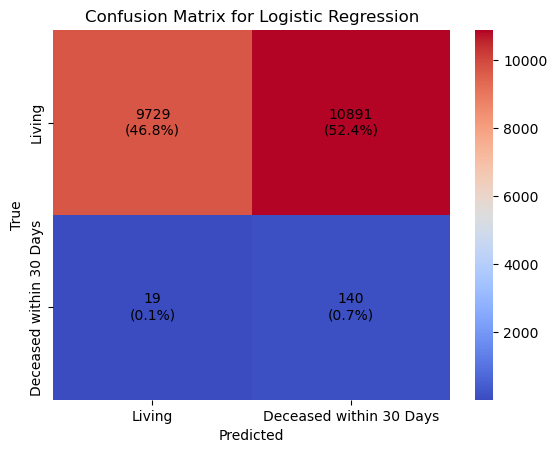


Logistic Regression:
AUC: 0.79 (95% CI: 0.76-0.82)
Accuracy: 0.48 (95% CI: 0.47-0.48)
Sensitivity: 0.88 (95% CI: 0.82-0.93)
Specificity: 0.47 (95% CI: 0.47-0.48)
F1-Score: 0.03 (95% CI: 0.02-0.03)
Relative Risk: 6.51 (95% CI: 4.11-11.51)
Absolute Risk High: 0.0127 (95% CI: 0.0107-0.0152)
Absolute Risk Low: 0.0019 (95% CI: 0.0011-0.0030)
Attributable Risk: 0.0107 (95% CI: 0.0086-0.0129)
P-value for group comparison: 0.000000000


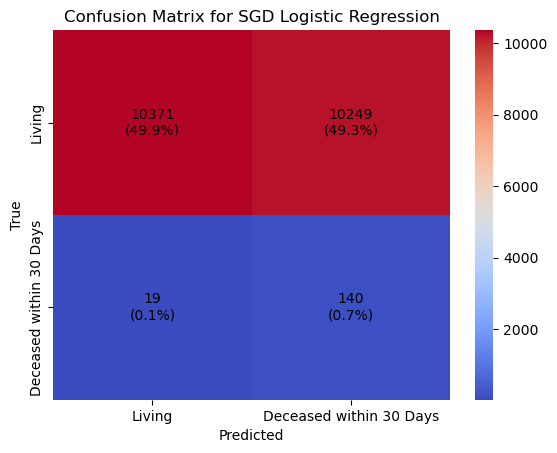


SGD Logistic Regression:
AUC: 0.79 (95% CI: 0.75-0.82)
Accuracy: 0.51 (95% CI: 0.50-0.51)
Sensitivity: 0.88 (95% CI: 0.82-0.93)
Specificity: 0.50 (95% CI: 0.50-0.51)
F1-Score: 0.03 (95% CI: 0.02-0.03)
Relative Risk: 7.37 (95% CI: 4.64-13.00)
Absolute Risk High: 0.0135 (95% CI: 0.0114-0.0162)
Absolute Risk Low: 0.0018 (95% CI: 0.0011-0.0028)
Attributable Risk: 0.0116 (95% CI: 0.0095-0.0140)
P-value for group comparison: 0.000000000


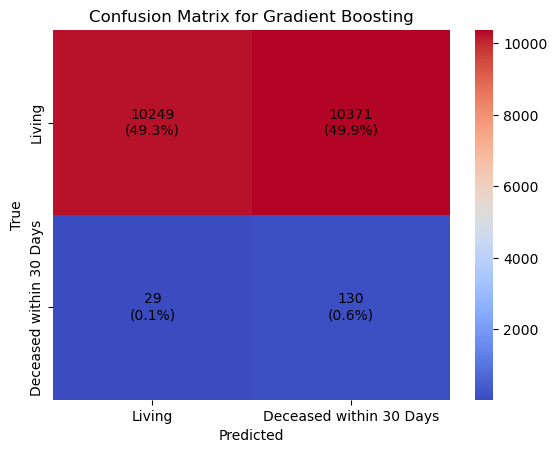


Gradient Boosting:
AUC: 0.73 (95% CI: 0.70-0.77)
Accuracy: 0.50 (95% CI: 0.49-0.51)
Sensitivity: 0.82 (95% CI: 0.77-0.87)
Specificity: 0.50 (95% CI: 0.49-0.50)
F1-Score: 0.02 (95% CI: 0.02-0.03)
Relative Risk: 4.39 (95% CI: 3.32-6.58)
Absolute Risk High: 0.0124 (95% CI: 0.0106-0.0145)
Absolute Risk Low: 0.0028 (95% CI: 0.0020-0.0040)
Attributable Risk: 0.0096 (95% CI: 0.0076-0.0118)
P-value for group comparison: 0.000000000


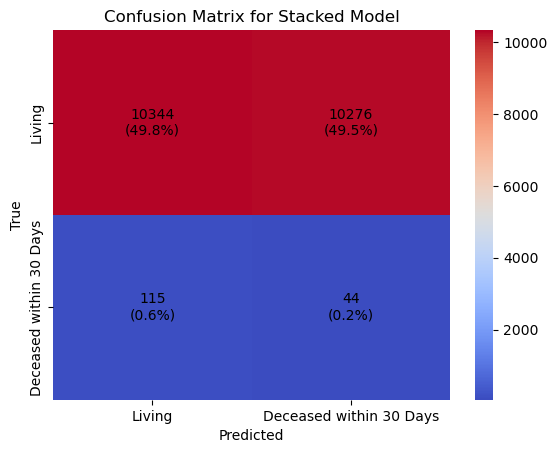


Stacked Model:
AUC: 0.33 (95% CI: 0.27-0.38)
Accuracy: 0.50 (95% CI: 0.49-0.51)
Sensitivity: 0.28 (95% CI: 0.20-0.34)
Specificity: 0.50 (95% CI: 0.50-0.51)
F1-Score: 0.01 (95% CI: 0.01-0.01)
Relative Risk: 0.39 (95% CI: 0.26-0.52)
Absolute Risk High: 0.0043 (95% CI: 0.0030-0.0054)
Absolute Risk Low: 0.0110 (95% CI: 0.0094-0.0132)
Attributable Risk: -0.0067 (95% CI: -0.0094--0.0046)
P-value for group comparison: 0.000000041


In [14]:
# # Load the variables back from the file
# with open('data_variables.pkl', 'rb') as f:
#     X_train, X_test, y_train, y_test = pickle.load(f)

# # Load stacked_model
# with open('trained_stacked_model.pkl', 'rb') as file:
#     trained_stacked_model = pickle.load(file)

# # Load all_models
# with open('trained_all_models.pkl', 'rb') as file:
#     trained_all_models = pickle.load(file)

print('Training performance results')
display_results(trained_stacked_model, trained_all_models, X_train, y_train, class_labels, target_fpr=0.5, plot_ci=False, n_bootstraps = n_bootstraps_for_results)

print('Testing performance results')
display_results(trained_stacked_model, trained_all_models, X_test, y_test, class_labels, target_fpr=0.5, plot_ci=False, n_bootstraps = n_bootstraps_for_results)

In [15]:
# For continuous variable AGE
subgroup_analysis('AGE', 'continuous', trained_stacked_model,trained_all_models, X_test, y_test)

# For categorical variable RACE
subgroup_analysis('RACE', 'categorical', trained_stacked_model,trained_all_models, X_test, y_test)

KeyError: 'AGE'

In [ ]:
race_columns = [col for col in X_test.columns if "RACE_" in col]
print(race_columns)

In [ ]:
if use_mini_dataset: 
    explainer, shap_values = model_interpretability(trained_stacked_model, X_small, y_small)
else:
    explainer, shap_values = model_interpretability(trained_stacked_model, X_test, y_test)

In [ ]:
# Compare results to control model which guesses the mean...

In [ ]:
# Visualize PCA class boundary?

In [ ]:
# # Visualize class boundaries using PCA
# if use_PCA:
#     colors = ['blue', 'red', 'green']
#     markers = ['s', 'x', 'o']
#     for l, c, m in zip(np.unique(y_train), colors, markers):
#         if three_class:
#             if l == 0:
#                 grade = 'Grade I'
#             elif l == 1:
#                 grade = 'Grade II'
#             else:
#                 grade = 'Grade III'
#         elif two_class:
#             if l == 0:
#                 grade = 'Grade I'
#             elif l == 1:
#                 grade = 'Grade II/III'
#         plt.scatter(X_train[y_train == l, 0], X_train[y_train == l, 1], c=c, label=grade, marker=m)

#     plt.xlabel('Principal Component 1')
#     plt.ylabel('Principal Component 2')
#     plt.legend(loc='best')
#     plt.title('Low-dimensional Visualization of Class Boundaries using PCA in Train Data')
#     plt.show()

#     colors = ['blue', 'red', 'green']
#     markers = ['s', 'x', 'o']
#     for l, c, m in zip(np.unique(y_test), colors, markers):
#         if three_class:
#             if l == 0:
#                 grade = 'Grade I'
#             elif l == 1:
#                 grade = 'Grade II'
#             else:
#                 grade = 'Grade III'
#         elif two_class:
#             if l == 0:
#                 grade = 'Grade I'
#             elif l == 1:
#                 grade = 'Grade II/III'
#         plt.scatter(X_test[y_test == l, 0], X_test[y_test == l, 1], c=c, label=grade, marker=m)

#     plt.xlabel('Principal Component 1')
#     plt.ylabel('Principal Component 2')
#     plt.legend(loc='best')
#     plt.title('Low-dimensional Visualization of Class Boundaries using PCA in Test Data')
#     plt.show()

# from matplotlib.lines import Line2D

# if use_PCA and number_of_PCA_components == 2:
#     models = {
#         'KNN': knn_model,
#         'Random Forest': rf_model,
#         'SVM': svm_model,
#         'Logistic Regression': lr_model
#     }

#     # Create a mesh grid for plotting decision boundaries
#     x_min, x_max = X_test[:, 0].min() - 1, X_test[:, 0].max() + 1
#     y_min, y_max = X_test[:, 1].min() - 1, X_test[:, 1].max() + 1
#     xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))

#     # Create a 3x1 grid of subplots
#     fig, axarr = plt.subplots(2, 2, figsize=(10, 10))
#     axarr = axarr.flatten()
    
#     colors = np.array(['blue', 'red'])
#     markers = np.array(['s', 'x'])

#     for idx, (name, model) in enumerate(models.items()):
#         if name == 'Logistic Regression':
#             y_logit = model(torch.tensor(np.c_[xx.ravel(), yy.ravel()], dtype=torch.float32)).detach().numpy()
#             y_prob = 1 / (1 + np.exp(-y_logit))
#             y_pred = np.where(y_prob[:, 0] > 0.5, 1, 0)
#             Z = y_pred.reshape(xx.shape)
#         else:
#             # Fit the model and predict on the mesh grid
#             Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
#             Z = Z.reshape(xx.shape)

#         # Plot the decision boundaries
#         axarr[idx].contourf(xx, yy, Z, alpha=0.8, cmap=plt.cm.coolwarm)
#         for i in range(len(X_test.tolist())):
#             axarr[idx].scatter(X_test[i, 0], X_test[i, 1], c=colors[y_test.astype(int)][i], marker=markers[y_test.astype(int)][i])
#         axarr[idx].set_xlabel('Feature 1')
#         axarr[idx].set_ylabel('Feature 2')
#         axarr[idx].set_title(name)

#     # Add the legend
#     legend_elements = [Line2D([0], [0], marker='s', color='w', label='Grade I', markerfacecolor='blue', markersize=10),
#                        Line2D([0], [0], marker='x', color='w', label='Grade II/III', markerfacecolor='red', markersize=10)]
#     plt.legend(handles=legend_elements, loc='lower right')

#     plt.tight_layout()
#     plt.show()


In [ ]:
# Record the end time
end_time = datetime.datetime.now()

# Calculate the total runtime
total_runtime = end_time - start_time

# Convert total runtime to a format of days, hours, minutes, and seconds
formatted_runtime = str(total_runtime).split('.')[0]  # Remove microseconds

print(f"Total runtime: {formatted_runtime}")

In [ ]:
# # TODO: Revisit normalizing transcripts based on tissue type

# # Toggle to use two-class labels or three class labels
# two_class = True; three_class = False #(Grade I/II, Grade III/IV)
# # three_class = True; two_class = False # (Grade I, Grade II, Grade III/IV)

# # Toggle to use_differentially_expressed_genes
# use_differentially_expressed_genes=True; first_n_diff_exp_genes = None # Use all differentially expressed genes
# # use_differentially_expressed_genes=True; first_n_diff_exp_genes = 500 # Use top 500 differentially expressed genes
# # use_differentially_expressed_genes=False # use all 19904 genes

# # Toggle to ignore zero values when normalizing the data
# # ignore_zero_for_normalization = False
# ignore_zero_for_normalization = True

# # Toggle to discretize z-scores into 3 or 5 groups (or don't discretize at all)
# # discretize_z_three = True; discretize_z_five = False
# # discretize_z_five = True; discretize_z_three = False
# discretize_z_five = False; discretize_z_three = False

# # Toggle to use various feature reduction methods (comment out/in as many as needed)
# use_lasso=True
# # use_lasso=False
# use_rfe=True; number_of_rfe_genes_to_keep = 100
# # use_rfe=False
# use_rf=True
# # use_rf=False
# use_boruta=True
# # use_boruta=False

# # Toggle how many feature reduction algoritms have to agree in order to accept a candidate feature-reduced gene to the final set of genes
# # overlap_mode = 'two_overlap'
# overlap_mode = 'all_overlap'

# # Toggle to use PCA to reduce dimensionality of data before passing into the algorithm
# # use_PCA=True; number_of_PCA_components = 10 # number_of_PCA_components must be less than first_n_diff_exp_genes
# use_PCA=False

# # We are using a bootstrap nested repeated k-fold cross validation procedure for training and testing
# # Decide the number of bootstraps to bootstrap the CV
# num_bootstrap_iterations = 100

# # Decide the number of repeats to run the repeated CV
# # num_repeats = 50
# num_repeats = 1

# # Decide the number of k-splits to run the k-fold CV
# num_splits = 5


In [ ]:
# print(f'{num_bootstrap_iterations}-fold Bootstrapped nested repeated cross validation F1-scores with confidence intervals on held-out test set')

# f1_scores = []

# control_f1s = []
# # Train the control model and compare results to other models
# for i in range(num_bootstrap_iterations):
#     # Resample the data with replacement to form a new dataset
#     X_resampled, y_resampled = resample(X_train, y_train, random_state=i)
#     # Find the single most important feature
#     # Here, we'll use the absolute correlation between each feature and the target variable as the measure of importance
#     feature_importance = np.abs(np.corrcoef(X_resampled.T, y_resampled)[0, 1:])
#     most_important_feature_index = np.argmax(feature_importance)
#     y_pred = np.zeros(len(X_test))

#     # Train the control model
#     # The model will simply predict the class based on the value of the most important feature
#     if two_class:
#         threshold = np.median(X_resampled[:, most_important_feature_index])
#         y_pred[X_test[:, most_important_feature_index] > threshold] = 0
#         y_pred[X_test[:, most_important_feature_index] <= threshold] = 1

#     if three_class:
#         # Find the thresholds for separating the three classes
#         threshold1 = np.percentile(X_resampled[:, most_important_feature_index], 33)
#         threshold2 = np.percentile(X_resampled[:, most_important_feature_index], 67)
#         y_pred[X_test[:, most_important_feature_index] <= threshold1] = 0
#         y_pred[(X_test[:, most_important_feature_index] > threshold1) & (X_test[:, most_important_feature_index] <= threshold2)] = 1
#         y_pred[X_test[:, most_important_feature_index] > threshold2] = 2

#     models = {
#         'Control Model': y_pred,
#         'KNN': best_knn_model_overall,
#         'Random Forest': best_rf_model_overall,
#         'SVM': best_svm_model_overall
#     }

#     # Compute the accuracy
#     accuracy = accuracy_score(y_test, y_pred)

#     conf_matrix = confusion_matrix(y_test, y_pred)

#     # Calculate Sensitivity and Specificity
#     sensitivity = np.diag(conf_matrix) / np.sum(conf_matrix, axis=1)
#     specificity = np.diag(conf_matrix) / np.sum(conf_matrix, axis=0)
#     f1 = f1_score(y_test, y_pred, average='weighted')

#     control_f1s.append(f1)

# control_CI = compute_CI(control_f1s)
# rf_CI = compute_CI(rf_bootstrap_f1_score)
# knn_CI = compute_CI(knn_bootstrap_f1_score)
# svm_CI = compute_CI(svm_bootstrap_f1_score)  
    
# f1_scores.append(('Control Model', np.mean(control_f1s), control_CI))
# f1_scores.append(('RF', np.mean(rf_bootstrap_f1_score), rf_CI))
# f1_scores.append(('KNN', np.mean(knn_bootstrap_f1_score), knn_CI))
# f1_scores.append(('SVM', np.mean(svm_bootstrap_f1_score), svm_CI))

# y_pred_majority = np.ones(len(X_test))
# f1_majority = f1_score(y_test, y_pred_majority, average='weighted')

# # Move the control model to the left
# # control_model = f1_scores.pop()
# # f1_scores.insert(0, control_model)

# # Sort models by F1 score
# # f1_scores.sort(key=lambda x: x[1], reverse=True)

# # Create bar plot
# labels, scores, CIs = zip(*f1_scores)
# lower_bounds, upper_bounds = zip(*CIs)
# # Calculate error bars
# y_err_lower = [score - lb for score, lb in zip(scores, lower_bounds)]
# y_err_upper = [ub - score for score, ub in zip(scores, upper_bounds)]
# plt.bar(labels, scores, yerr=[y_err_lower, y_err_upper], capsize=5, color='skyblue', ecolor='black')
# plt.xlabel('Model', fontsize=14)
# plt.ylabel('F1-Score', fontsize=14)
# plt.title('F1-Score Comparison of Models on Test Set', fontsize=16)
# plt.xticks(fontsize=12)
# plt.yticks(fontsize=12)
# plt.axhline(y=f1_majority, color='red', linestyle='dotted', label='Predict Majority Class for All')
# plt.legend(fontsize=12)
# plt.ylim([0,1])
# plt.tight_layout()
# plt.show()
